# Import stuff

In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', font_scale=1.5)
from scipy import stats
import sys

from IPython.display import display, Markdown

# operon python bindings
import pyoperon as Operon

# Load some data

In [2]:
ds = Operon.Dataset('../data/Poly-10.csv', has_header=True)
training_range = Operon.Range(0, ds.Rows // 2)
test_range = Operon.Range(training_range.End, ds.Rows)

target = ds.GetVariable('Y')
y_train = ds.Values[0:training_range.End, target.Index]

inputs = Operon.VariableCollection(v for v in ds.Variables if v.Name != target.Name)

# Set up algorithm parameters

In [3]:
grammar = Operon.Grammar()
grammar.SetConfig(Operon.Grammar.Arithmetic)

rng = Operon.RomuTrio(random.randint(1, 100000))
btc = Operon.BalancedTreeCreator(grammar, inputs, bias=0.0)

population_size = 1000
min_length, max_length = 1, 50
min_depth, max_depth = 1, 10
p_crossover = 1.0
p_mutation  = 0.25
p_internal = 0.9 # for crossover
initial_lengths = np.random.randint(min_length, max_length+1, population_size)
max_generations = 1000

# Set up genetic operators

In [4]:
crossover      = Operon.SubtreeCrossover(p_internal, max_depth, max_length)
mut_onepoint   = Operon.OnePointMutation()
mut_changeVar  = Operon.ChangeVariableMutation(inputs)
mut_changeFunc = Operon.ChangeFunctionMutation(grammar)
mut_replace    = Operon.ReplaceSubtreeMutation(btc, max_length, max_depth)
mutation       = [ mut_onepoint, mut_changeFunc, mut_replace, mut_changeVar ]

def evaluate(ind):
    y_pred = Operon.Evaluate(ind, ds, training_range)
    return Operon.RSquared(y_pred, y_train)

def select(pop):
    i = random.randrange(population_size)
    for _ in range(1, 5):
        j = random.randrange(population_size)
        if pop[i][1] < pop[j][1]:
            i = j
        
    return pop[i]

def recombine(pop):
    do_crossover = random.uniform(0, 1) < p_crossover
    do_mutation = random.uniform(0, 1) < p_mutation

    p1, f1 = select(pop)

    if do_crossover:
        p2, f2 = select(pop) 
        child = crossover(rng, p1, p2)
    
    if do_mutation:
        op = random.choice(mutation)
        p1 = child if do_crossover else p1
        child = op(rng, child)
        
    if do_crossover or do_mutation:
        return child, evaluate(child)
    else:
        return p1, f1

def initialize(i):
    x = btc(rng, initial_lengths[i], 0, 0)
    f = evaluate(x)
    return x, f 

# Run GP

In [5]:
if __name__ == '__main__':
    t0 = time.time()
    pop = [initialize(i) for i in range(population_size)]
    best = np.argmax([p[1] for p in pop])
    
    max_ticks = 50
    interval = 1 if max_generations < max_ticks else int(np.round(max_generations / max_ticks, 0))

    for gen in range(max_generations+1):
        tmp = [pop[best] if i == best else recombine(pop) for i in range(population_size)]
        tmp, pop = pop, tmp
        best = np.argmax([p[1] for p in pop])

        if gen % interval == 0:
            print('\u2592', end='')
            
    t1 = time.time()
    best_model, best_quality = pop[best]
    print(f'\nbest quality: {best_quality:.6f}, elapsed: {t1-t0} seconds')


▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
best quality: 0.999997, elapsed: 14.841397047042847 seconds


## Export the model as an infix string and parse it with sympy

### Model

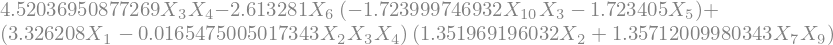

### Simplified model

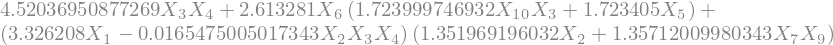

In [6]:
    infix = Operon.InfixFormatter.Format(best_model, ds, 6)

    import sympy as sy
    from sympy.parsing.sympy_parser import parse_expr
    from sympy import simplify

    sy.init_printing(use_unicode=True)

    expr = parse_expr(infix)
    display(Markdown('### Model'))
    display(expr)

    display(Markdown('### Simplified model'))
    simplified = simplify(expr)
    display(simplified)

# Visualize the results

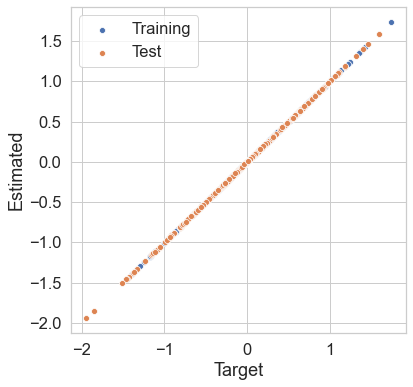

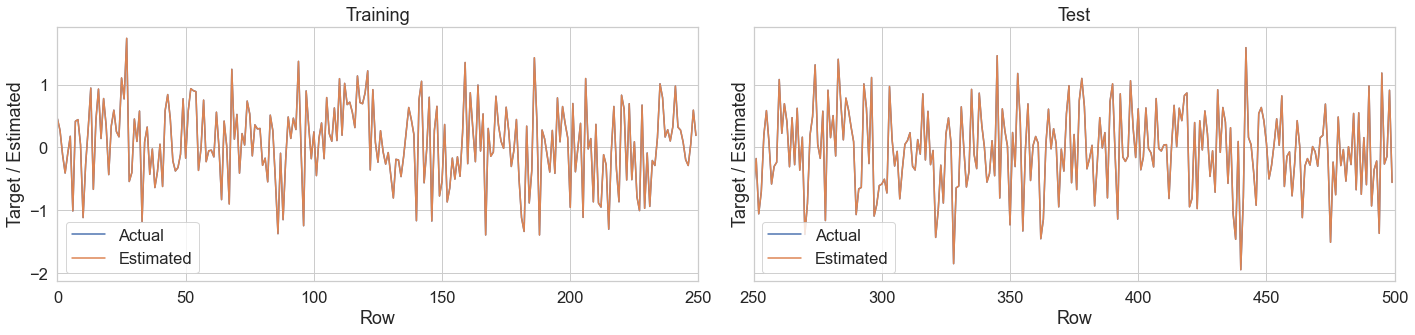

In [7]:
    xs = range(0, ds.Rows)
    y_target = ds.Values[0:ds.Rows, target.Index]

    y_pred = Operon.Evaluate(best_model, ds, Operon.Range(0, ds.Rows))
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression().fit(y_pred.reshape(500, 1), y_target)
    y_scaled = lr.coef_ * y_pred + lr.intercept_
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    sns.scatterplot(y_target[training_range.Start:training_range.End], y_scaled[training_range.Start:training_range.End], ax=ax, label='Training')
    sns.scatterplot(y_target[test_range.Start:test_range.End], y_scaled[test_range.Start:test_range.End], ax=ax, label='Test')
    ax.set(xlabel='Target', ylabel='Estimated')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5), sharey=True)

    ax = axes[0]
    sns.lineplot(ax=ax, x=xs[training_range.Start:training_range.End], y=y_target[training_range.Start:training_range.End], label='Actual')
    sns.lineplot(ax=ax, x=xs[training_range.Start:training_range.End], y=y_scaled[training_range.Start:training_range.End], label='Estimated')
    ax.set(xlabel='Row', ylabel='Target / Estimated', title='Training')
    ax.set_xlim(training_range.Start, training_range.End)

    ax = axes[1]
    sns.lineplot(ax=ax, x=xs[test_range.Start:test_range.End], y=y_target[test_range.Start:test_range.End], label='Actual')
    sns.lineplot(ax=ax, x=xs[test_range.Start:test_range.End], y=y_scaled[test_range.Start:test_range.End], label='Estimated')
    ax.set(xlabel='Row', ylabel='Target / Estimated', title='Test')
    ax.set_xlim(test_range.Start, test_range.End)

    plt.tight_layout()